# Quickstart to parcels

(Boiled down from: https://docs.oceanparcels.org/en/v3.0.4/examples/parcels_tutorial.html)

## Basic setup

In [1]:
from pathlib import Path
example_data_path = Path("../parcels_example_data/")

## Importing relevant modules

We need to import `parcels` itself along with `matplotlib`, `xarray`, and `datetime`.

In [2]:
import parcels

from matplotlib import pyplot as plt
import xarray as xr
import datetime

## Moving Eddies: Idealised field

Create fieldsset w/ `.from_parcels()` on the "MovingEddies_data" dataset (where individual files are called `"moving_eddies?.nc"`:

In [3]:
fieldset = parcels.FieldSet.from_parcels(
    example_data_path / "MovingEddies_data" / "moving_eddies",
)
fieldset

Have a look:
- `fieldset.computeTimeChunk()` loads data
- plot `fieldset.U.data[0, :, :]` against its cooreds `fieldset.U.grid.lon`, and `fieldset.U.grid.lat`.

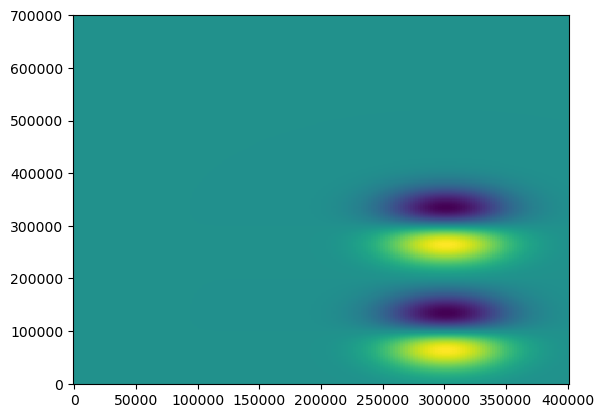

In [4]:
fieldset.computeTimeChunk()

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])

Create a particleset using `ParticleSet.from_list()` starting on the `lon=3.3e5` line.

In [5]:
particleset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=parcels.JITParticle,
    lon=[3.3e5, 3.3e5],
    lat=[1.5e5, 2.8e5],
)

Have a look at the `particleset`. (Print and plot `pset.lon` and `pset.lat` along with the `fieldset`.)

In [6]:
print(particleset)

P[0](lon=330000.000000, lat=150000.000000, depth=0.000000, time=not_yet_set)
P[1](lon=330000.000000, lat=280000.000000, depth=0.000000, time=not_yet_set)


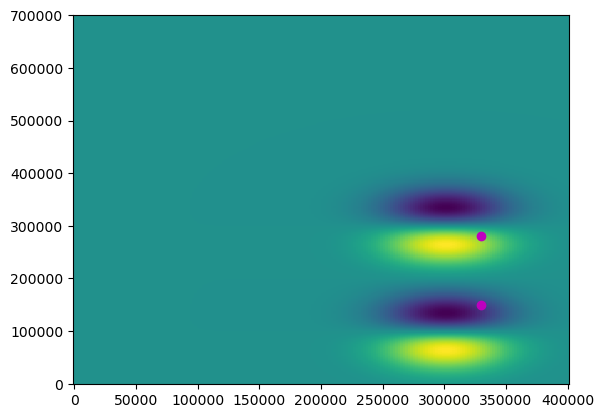

In [7]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.plot(particleset.lon, particleset.lat, 'mo')

Let particles evolve with the `AdvectionRK4` `kernel`, using a `runtime` of 3 days with a 5 minute time step `dt`.

In [8]:
particleset.execute(
    parcels.AdvectionRK4,
    runtime=datetime.timedelta(days=3),
    dt=datetime.timedelta(minutes=5),
)

100%|██████████████████████████| 259200.0/259200.0 [00:00<00:00, 7763014.46it/s]


Have a look at the new particle positions.

In [9]:
print(particleset)

P[0](lon=308019.468750, lat=146597.250000, depth=0.000000, time=258900.000000)
P[1](lon=296370.875000, lat=298952.625000, depth=0.000000, time=258900.000000)


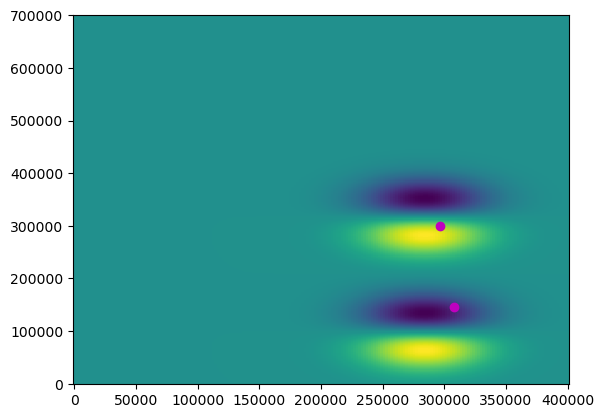

In [10]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.plot(particleset.lon, particleset.lat, 'mo')

Define a `ParticleFile` (passed to `.execute()` as `output_file`) "EddyParticles.zarr" with an `outputdt` of 1 hour and execute the `particleset` again for 3 days.

In [11]:
output_file = particleset.ParticleFile(
    name="EddyParticles.zarr",
    outputdt=datetime.timedelta(hours=1),
)
particleset.execute(
    parcels.AdvectionRK4,
    runtime=datetime.timedelta(days=3),
    dt=datetime.timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in EddyParticles.zarr.
100%|████████████████████████████| 259200.0/259200.0 [00:09<00:00, 26856.77it/s]


In [12]:
print(particleset)

P[0](lon=280833.125000, lat=146932.718750, depth=0.000000, time=518100.000000)
P[1](lon=260835.125000, lat=320403.343750, depth=0.000000, time=518100.000000)


Have a look at the output file with `xarray` (using `.open_zarr()`).

In [13]:
ds_particles = xr.open_zarr("EddyParticles.zarr/")

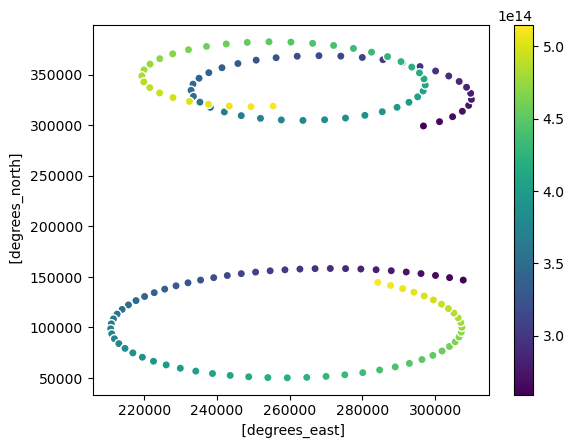

In [14]:
ds_particles.plot.scatter(x="lon", y="lat", hue="time")

Run particles backward in time for 6 days and compare the recorded trajectories.

In [15]:
output_file = particleset.ParticleFile(
    name="EddyParticles_bw.zarr",  # the file name
    outputdt=datetime.timedelta(hours=1),  # the time step of the outputs
)
particleset.execute(
    parcels.AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=datetime.timedelta(days=6),  # the total length of the run
    dt=-datetime.timedelta(minutes=5),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Output files are stored in EddyParticles_bw.zarr.
100%|████████████████████████████| 518400.0/518400.0 [00:17<00:00, 29888.05it/s]


In [16]:
print(particleset)

P[0](lon=329684.000000, lat=150185.390625, depth=0.000000, time=300.000000)
P[1](lon=330289.968750, lat=280418.906250, depth=0.000000, time=300.000000)


Have a look with Xarray and compare both output files

In [17]:
ds_particles_bw = xr.open_zarr("EddyParticles_bw.zarr/")

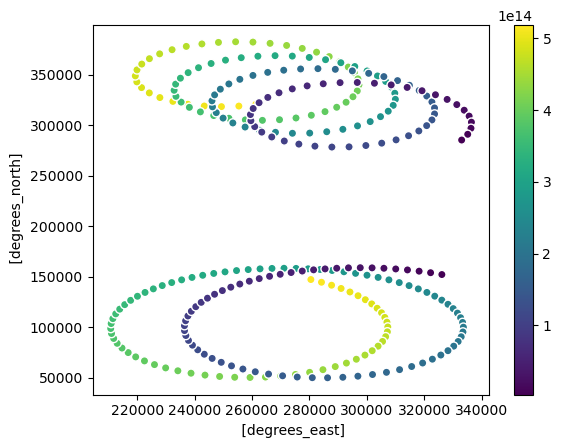

In [18]:
ds_particles_bw.plot.scatter(x="lon", y="lat", hue="time", marker="o")

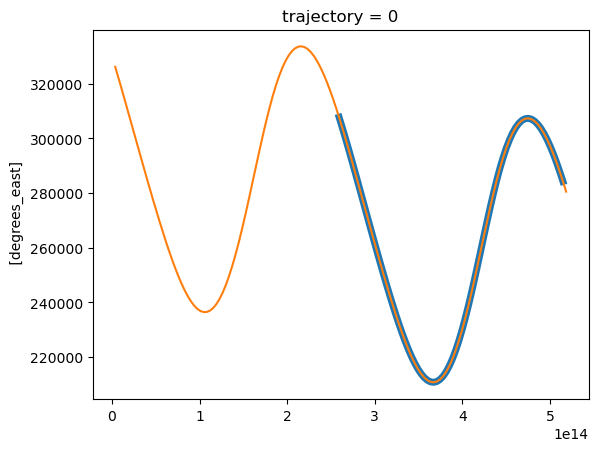

In [19]:
ds_particles.set_coords("time").isel(trajectory=0).lon.plot(x="time", linewidth=5)
(ds_particles_bw.set_coords("time").isel(trajectory=0).lon).plot(x="time")